<a href="https://colab.research.google.com/github/LuisRodarteSolorzano/Econometria_Analisis_de_Datos_e_IA_en_software/blob/main/bayesian_clustering_households.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de hogares con enfoque tradicional vs bayesiano

En este notebook construimos un **proyecto aplicando econometría bayesiana** a una encuesta de hogares.

Objetivos:

1. Generar una **base de hogares** con variables típicas:
   - Ingreso del hogar
   - Tamaño del hogar
   - Educación del jefe/jefa
   - Zona urbana / rural
   - Región (Costa / Sierra / Selva)
2. Aplicar un **enfoque tradicional de clustering** (K–means) para formar grupos de hogares según ingreso y características.
3. Aplicar un **enfoque bayesiano de clustering** usando un **mixture model gaussiano bayesiano** (variational Bayes: `BayesianGaussianMixture`).
4. Comparar grupos tradicionales vs bayesianos.
5. Usar los clusters bayesianos para una **imputación de datos faltantes de ingreso** (comparando imputación determinista vs imputación bayesiana).




## 1. Setup

Primero cargamos las librerías necesarias.

> Si en tu entorno no tienes alguna de estas librerías, puedes instalarla con:
>
> ```bash
> pip install numpy pandas matplotlib seaborn scikit-learn
> ```


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture

np.random.seed(30112025)  # para reproducibilidad

sns.set(style="whitegrid")



## 2.Datos de encuesta de hogares

Base con `N = 4000` hogares con las siguientes variables:

- `region`: Costa, Sierra, Selva (codificada 0/1/2).
- `urban`: 1 = urbano, 0 = rural.
- `hh_size`: tamaño del hogar.
- `edu_head`: años de educación del jefe del hogar.
- `labor_income`: ingreso laboral mensual del hogar.
- `transfers`: transferencias (bonos, remesas, etc.).
- `total_income`: ingreso total mensual del hogar.
- `log_income`: logaritmo del ingreso total.

Notar que los **variables cambiaran por región y área** (por ejemplo, mayor ingreso en ciudades de la Costa, menor en zonas rurales de Sierra/Selva) para clusters.


Importamos el conjunto de datos

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_excel("/content/drive/MyDrive/Econometria Analisis de Datos e IA en software/households_survey.xlsx")
df.head()

,region,urban,hh_size,edu_head,labor_income,transfers,total_income,log_income
0,Costa,1,6,8,15541.060891,0.000000,15541.060891,9.651241
1,Costa,1,6,8,9025.844279,769.350257,9795.194536,9.189647
2,Selva,1,4,4,4019.104770,731.136556,4750.241326,8.465951
3,Sierra,0,7,7,6313.139780,0.000000,6313.139780,8.750388
4,Sierra,1,2,9,6484.053445,1452.062254,7936.115699,8.979179


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## 3. Exploración descriptiva

Antes de hacer clustering, miramos la distribución de ingresos y algunas relaciones con otras variables.


In [ ]:

df.describe(include="all")

,region,urban,hh_size,edu_head,labor_income,transfers,total_income,log_income
count,4000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Costa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.708750,4.490750,9.151750,8980.581453,474.232145,9454.813597,9.029056
std,NaN,0.454395,1.852774,2.902469,4860.486163,563.399530,4892.428979,0.503943
min,NaN,0.000000,1.000000,0.000000,1337.391260,0.000000,1337.391260,7.198476
25%,NaN,0.000000,3.000000,7.000000,5336.744999,0.000000,5811.814460,8.667648
50%,NaN,1.000000,4.000000,9.000000,7821.428956,370.819582,8354.484385,9.030554
75%,NaN,1.000000,6.000000,11.000000,11447.809750,747.453262,12002.660119,9.392884


In [6]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
region,4000,3,Costa,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
urban,4000.0,NaN,NaN,NaN,0.70875,0.454395,0.0,0.0,1.0,1.0,1.0
hh_size,4000.0,NaN,NaN,NaN,4.49075,1.852774,1.0,3.0,4.0,6.0,12.0
edu_head,4000.0,NaN,NaN,NaN,9.15175,2.902469,0.0,7.0,9.0,11.0,18.0
labor_income,4000.0,NaN,NaN,NaN,8980.581453,4860.486163,1337.39126,5336.744999,7821.428956,11447.80975,38569.738764
transfers,4000.0,NaN,NaN,NaN,474.232145,563.39953,0.0,0.0,370.819582,747.453262,6516.116808
total_income,4000.0,NaN,NaN,NaN,9454.813597,4892.428979,1337.39126,5811.81446,8354.484385,12002.660119,38569.738764
log_income,4000.0,NaN,NaN,NaN,9.029056,0.503943,7.198476,8.667648,9.030554,9.392884,10.560223


Realizamos algunas figuras como distribucion de ingresos por area y region

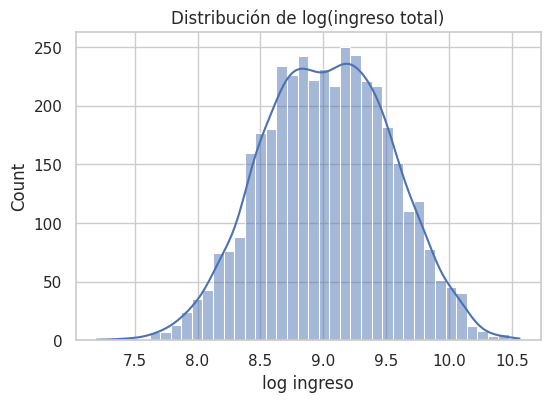

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df["log_income"], kde=True, bins=40)
plt.title("Distribución de log(ingreso total)")
plt.xlabel("log ingreso")
plt.show()

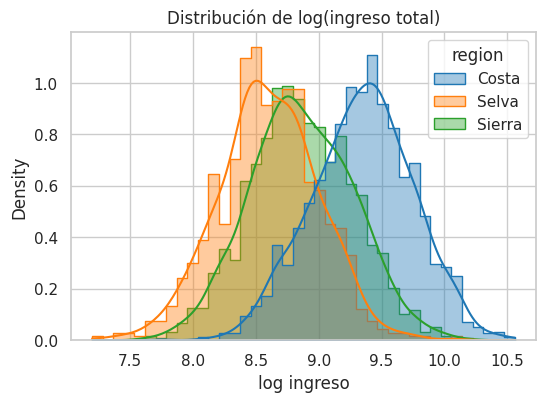

In [8]:

plt.figure(figsize=(6,4))
sns.histplot(data=df, x="log_income", hue="region",
             kde=True, bins=40, element="step",
             stat="density", common_norm=False,
             palette="tab10", alpha=0.4)
plt.title("Distribución de log(ingreso total)")
plt.xlabel("log ingreso")
plt.show()


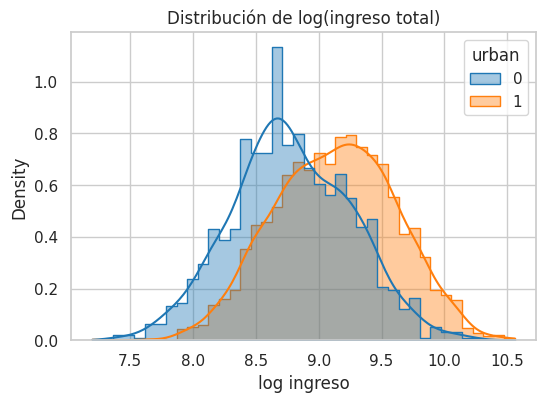

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="log_income", hue="urban",
             kde=True, bins=40, element="step",
             stat="density", common_norm=False,
             palette="tab10", alpha=0.4)
plt.title("Distribución de log(ingreso total)")
plt.xlabel("log ingreso")
plt.show()


Ingreso versus educacion

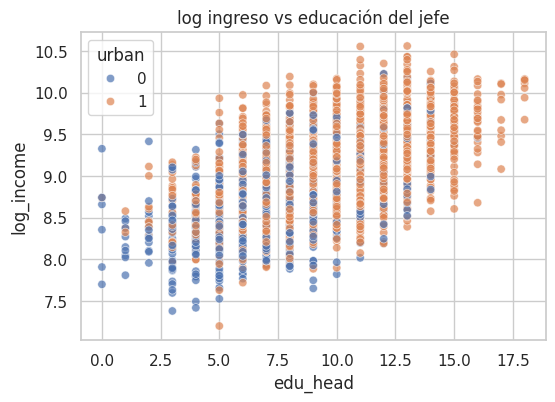

In [10]:

plt.figure(figsize=(6,4))
sns.scatterplot(data=df,
                x="edu_head", y="log_income",
                hue="urban", alpha=0.7)
plt.title("log ingreso vs educación del jefe")
plt.show()


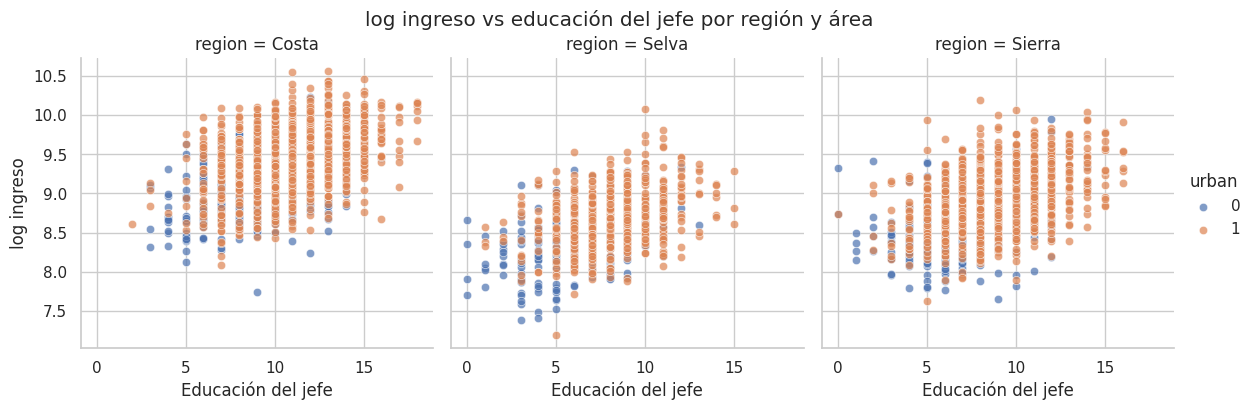

In [11]:
g = sns.FacetGrid(df,
                  col="region",          # un gráfico por región
                  hue="urban",           # color por área (urbano/rural)
                  col_wrap=3,            # cuántas columnas de gráficos
                  height=4,
                  sharex=True, sharey=True)

g.map_dataframe(sns.scatterplot,
                x="edu_head",
                y="log_income",
                alpha=0.7)

g.add_legend()
g.set_axis_labels("Educación del jefe", "log ingreso")
g.fig.suptitle("log ingreso vs educación del jefe por región y área", y=1.02)
plt.show()



## 4. Clustering tradicional: K–means

### 4.1 Variables para clustering

Vamos a formar grupos de hogares usando las variables:

- `log_income` (ingreso)
- `hh_size` (tamaño del hogar)
- `edu_head` (educación del jefe)
- `urban` (urbano/rural, codificada 0/1)

Primero estandarizamos las variables para que K–means no se vea dominado por la magnitud del ingreso.


In [12]:
features = ["log_income", "hh_size", "edu_head", "urban"]
X = df[features].values

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_std[:5]


array([[ 1.23478935,  0.81469108, -0.3968669 ,  0.64104192],
       [ 0.3187099 ,  0.81469108, -0.3968669 ,  0.64104192],
       [-1.11753908, -0.26490618, -1.77517609,  0.64104192],
       [-0.55304362,  1.3544897 , -0.7414442 , -1.55996038],
       [-0.09898509, -1.34450343, -0.0522896 ,  0.64104192]])

### 4.2 K–means con \(K=3\) grupos

El algoritmo K–means busca **particiones que minimicen la suma de distancias cuadráticas** a los centroides:

$$
\min_{\{\mu_k\}, \{C_k\}} \sum_{k=1}^K \sum_{i \in C_k} \|x_i - \mu_k\|^2.
$$

En la figura siguiente se muestra un ejemplo **teórico** con datos simulados en 2 dimensiones y $K=3$ clústeres.  
Los puntos de colores representan las observaciones asignadas a cada clúster y las “X” rojas son los centroides $\mu_k$ estimados por K–means.


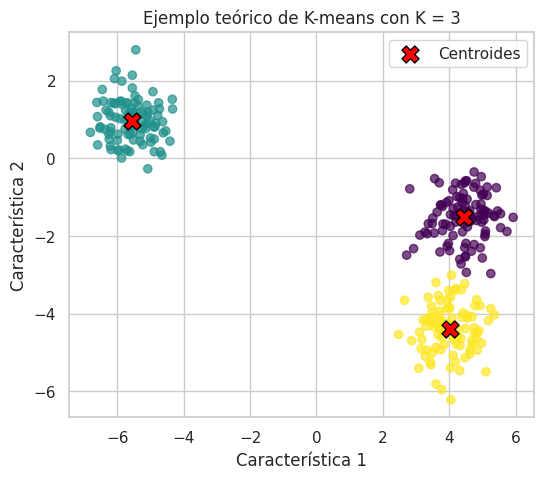

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# 1. Datos simulados: 3 grupos en 2D
X, _ = make_blobs(
    n_samples=300,
    centers=3,
    cluster_std=0.6,
    random_state=123
)

# 2. Ajustar K-means con K=3
kmeans = KMeans(n_clusters=3, random_state=123, n_init=10)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# 3. Gráfico
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X[:, 0], X[:, 1],
    c=labels, cmap="viridis",
    alpha=0.7
)

plt.scatter(
    centers[:, 0], centers[:, 1],
    c="red", s=150, marker="X",
    edgecolor="black", label="Centroides"
)

plt.title("Ejemplo teórico de K-means con K = 3")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.legend()
plt.show()


### Algoritmo K–means (visión general)

El algoritmo **K–means** es un método de *clustering* que, dado un número de grupos \(K\), busca **particionar** un conjunto de datos en \(K\) clústeres de forma que los puntos dentro de cada clúster sean lo más parecidos posible (en distancia Euclídea) a su centroide.

---

### 1. Datos y objetivo

Supongamos que tenemos \(n\) observaciones

$$
x_1, x_2, \dots, x_n \in \mathbb{R}^d
$$

y queremos separarlas en \(K\) grupos (clústeres) \(C_1, \dots, C_K\) con centroides $\mu_1, \dots, \mu_K$.

El objetivo de K–means es **minimizar la suma de distancias cuadráticas** de cada punto a su centroide:

$$
\min_{\{C_k\}, \{\mu_k\}}
J = \sum_{k=1}^K \sum_{x_i \in C_k} \|x_i - \mu_k\|^2.
$$

- $\|x_i - \mu_k\|^2$ es la distancia Euclídea al cuadrado.
- $J$ es la “función de costo” o **inercia total**.

---

### 2. Idea básica del algoritmo

K–means alterna dos pasos:

1. **Asignación de clústeres** (given $\mu_k$)
2. **Actualización de centroides** (given $C_k$)

hasta que el algoritmo converja.

---

### 3. Paso de asignación

Dado un conjunto actual de centroides $\{\mu_1, \dots, \mu_K\}$, asignamos cada punto $x_i$ al clúster **más cercano** (en distancia Euclídea):

$$
c_i = \arg\min_{k \in \{1,\dots,K\}} \|x_i - \mu_k\|^2,
$$

donde $c_i$ es la etiqueta de clúster del punto $x_i$, y por tanto:

$$
x_i \in C_{c_i}.
$$

---

### 4. Paso de actualización

Una vez que tenemos la partición $\{C_1,\dots,C_K\}$, recalculamos cada centroide como el **promedio** de los puntos asignados a ese clúster:

$$
\mu_k = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_i,
\qquad k = 1,\dots,K.
$$

- Es decir, $\mu_k$ es la **media aritmética** de los puntos del clúster $k$.

---

### 5. Esquema completo del algoritmo

1. Elegir $K$ (número de clústeres).
2. **Inicializar** los centroides $\mu_1, \dots, \mu_K$ (por ejemplo, al azar).
3. Repetir hasta convergencia:
   - (a) Asignar cada punto al clúster más cercano (paso de asignación).
   - (b) Recalcular los centroides como la media de los puntos de cada clúster (paso de actualización).
4. Parar cuando:
   - las asignaciones ya no cambian, o  
   - la reducción en $J$ es muy pequeña.

---

- K–means **no tiene una interpretación probabilística explícita** (a diferencia de un modelo de mezcla de Gaussianas); simplemente **minimiza** la función de costo \(J\).
- El resultado depende de:
  - la elección de \(K\),
  - la inicialización de los centroides (por eso se usa `n_init` con varios intentos),
  - la escala de las variables (es común estandarizar los datos).
- El algoritmo garantiza converger a **un mínimo local** de $J$, no necesariamente al mínimo global.

Revisar las librerías como `scikit-learn` (`KMeans`).


## Aplicamos el algortimo K means en nuestro conjunto de datos de hogares

In [14]:
# Número de clústeres que queremos (K = 3)
k = 3

# Definimos el modelo K-Means:
# - n_clusters=k → cantidad de grupos
# - random_state=123 → semilla para reproducibilidad
# - n_init=20 → número de inicializaciones distintas (elige la mejor)
kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)

# Ajustamos el modelo con los datos estandarizados X_std
# y guardamos la etiqueta de clúster de cada observación en una nueva columna
# del DataFrame llamada "cluster_km"
df["cluster_km"] = kmeans.fit_predict(X_std)

# Contamos cuántas observaciones hay en cada clúster
# y las ordenamos por el índice del clúster (0, 1, 2)
df["cluster_km"].value_counts().sort_index()



,count
cluster_km,
0,1116
1,1436
2,1448


In [15]:
df

,region,urban,hh_size,edu_head,labor_income,transfers,total_income,log_income,cluster_km
0,Costa,1,6,8,15541.060891,0.000000,15541.060891,9.651241,1
1,Costa,1,6,8,9025.844279,769.350257,9795.194536,9.189647,2
2,Selva,1,4,4,4019.104770,731.136556,4750.241326,8.465951,2
3,Sierra,0,7,7,6313.139780,0.000000,6313.139780,8.750388,0
4,Sierra,1,2,9,6484.053445,1452.062254,7936.115699,8.979179,2
...,...,...,...,...,...,...,...,...,...
3995,Sierra,0,4,0,5301.929380,953.161354,6255.090734,8.741151,0
3996,Costa,1,3,7,12860.893924,374.375586,13235.269510,9.490640,2
3997,Costa,1,3,10,13679.267716,1011.949431,14691.217147,9.595005,1
3998,Costa,0,4,7,8178.463934,0.000000,8178.463934,9.009260,0


In [16]:

# Centroide de cada cluster (en escala original)
centroids_std = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_std)

centroids_df = pd.DataFrame(centroids, columns=features)
centroids_df.index.name = "cluster_km"
centroids_df


,log_income,hh_size,edu_head,urban
cluster_km,,,,
0,8.741282,4.437276,7.488351,-1.698641e-14
1,9.496019,4.541144,11.746862,9.658298e-01
2,8.788732,4.482069,7.865517,1.000000e+00


Elbow method (prueba del codo)

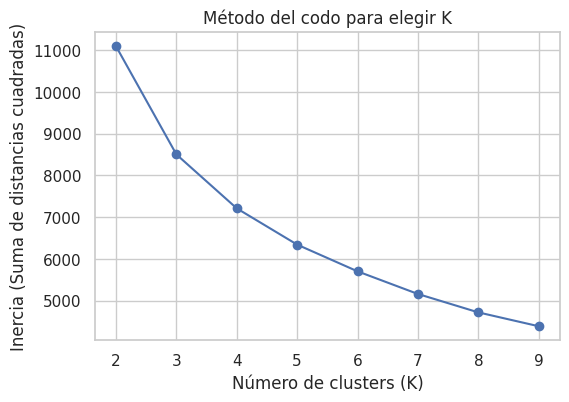

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de K que quieres evaluar (ajusta si quieres probar más)
Ks = range(2, 10)

inertias = []
silhouettes = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=123, n_init=20)
    labels = km.fit_predict(X_std)

    inertias.append(km.inertia_)                    # suma de distancias cuadradas
    silhouettes.append(silhouette_score(X_std, labels))  # promedio silhouette

# ---------- Gráfico 1: Elbow ----------
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker="o")
plt.xticks(Ks)
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (Suma de distancias cuadradas)")
plt.title("Método del codo para elegir K")
plt.grid(True)
plt.show()



Gráfico de los clústeres (ejemplo con edu_head vs log_income)

In [19]:
k_opt = 3  # cambia este valor según lo que decidas

kmeans = KMeans(n_clusters=k_opt, random_state=123, n_init=20)
df["cluster_km"] = kmeans.fit_predict(X_std)


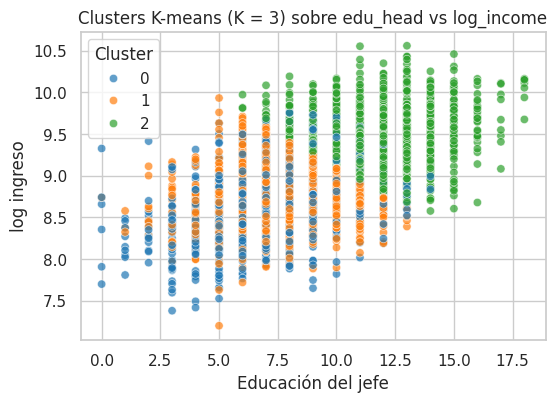

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df,
    x="edu_head",
    y="log_income",
    hue="cluster_km",
    palette="tab10",
    alpha=0.7
)
plt.title(f"Clusters K-means (K = {k_opt}) sobre edu_head vs log_income")
plt.xlabel("Educación del jefe")
plt.ylabel("log ingreso")
plt.legend(title="Cluster")
plt.show()


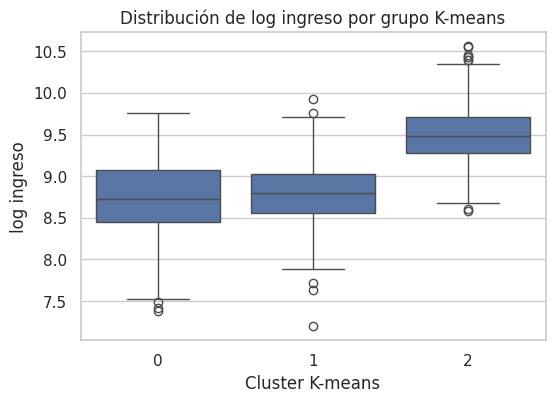

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="cluster_km", y="log_income")
plt.title("Distribución de log ingreso por grupo K-means")
plt.xlabel("Cluster K-means")
plt.ylabel("log ingreso")
plt.show()


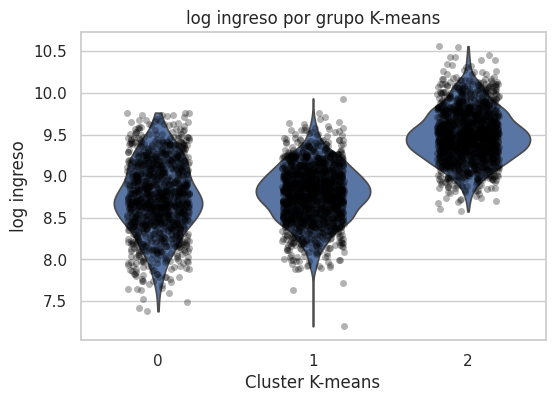

In [22]:
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x="cluster_km", y="log_income", inner=None, cut=0)
sns.stripplot(data=df, x="cluster_km", y="log_income",
              color="black", alpha=0.3, jitter=0.2)
plt.title("log ingreso por grupo K-means")
plt.xlabel("Cluster K-means")
plt.ylabel("log ingreso")
plt.show()


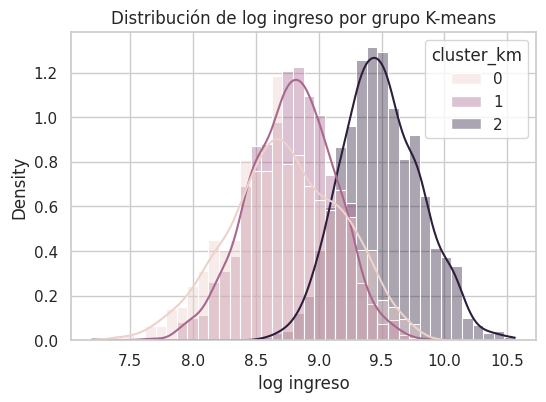

In [23]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="log_income", hue="cluster_km",
             kde=True, stat="density", common_norm=False,
             bins=40, alpha=0.4)
plt.title("Distribución de log ingreso por grupo K-means")
plt.xlabel("log ingreso")
plt.show()


## BayesianGaussianMixture

## 5. Clustering bayesiano: mezcla gaussiana bayesiana

Aquí ya no pensamos en “partir el espacio” como en K-means, sino en un **modelo probabilístico** para los datos.

Imaginemos que cada hogar tiene un vector de características

$$
\mathbf{x}_i \in \mathbb{R}^d,
$$

por ejemplo: $[ \text{log\_income}, \text{edu\_head}, \text{hh\_size}, \dots ]$.

### 5.1. Mezcla de gaussianas (modelo generativo)

Suponemos que cada hogar pertenece a **algún cluster oculto** $z_i \in \{1,\dots,K\}$:

- Primero se elige un cluster con probabilidad

  $$
  P(z_i = k) = \pi_k, \quad k = 1,\dots,K,
  $$

- Luego, dado el cluster $k$, el vector $\mathbf{x}_i$ se genera de una distribución normal multivariada:

  $$
  \mathbf{x}_i \mid (z_i = k) \sim \mathcal{N}(\mu_k, \Sigma_k).
  $$

Si no miramos el cluster $z_i$ (es decir, lo tratamos como no observado), la distribución total de $\mathbf{x}_i$ es una **mezcla de gaussianas**:

$$
p(\mathbf{x}_i) = \sum_{k=1}^K \pi_k \, \mathcal{N}(\mathbf{x}_i \mid \mu_k, \Sigma_k).
$$

donde:

- $\pi_k$ son los **pesos** o probabilidades de cada cluster (suman 1):

  $$
  \sum_{k=1}^K \pi_k = 1,
  \qquad
  \pi_k \ge 0.
  $$

- $\mu_k$ es el **vector de medias** del cluster $k$.
- $\Sigma_k$ es la **matriz de covarianza** del cluster $k$.

**Clustering** aquí significa: a partir de los datos observados $\{\mathbf{x}_i\}$, queremos inferir:

1. Los parámetros del modelo: $\pi_k$, $\mu_k$, $\Sigma_k$.
2. La probabilidad de que cada hogar pertenezca a cada cluster:

   $$
   P(z_i = k \mid \mathbf{x}_i) \quad \text{(asignación “suave” o probabilística)}.
   $$

---

### 5.2. Enfoque bayesiano

En el enfoque bayesiano, **no** tratamos a $\pi_k$, $\mu_k$, $\Sigma_k$ como parámetros fijos, sino como **variables aleatorias** con distribuciones a priori:

1. **Prior para los pesos**:

   Se usa un **prior de Dirichlet** sobre el vector de pesos

   $$
   \boldsymbol{\pi} = (\pi_1, \dots, \pi_K),
   $$

   con parámetros $\alpha_1,\dots,\alpha_K$:

   $$
   \boldsymbol{\pi} \sim \text{Dirichlet}(\alpha_1, \dots, \alpha_K).
   $$

   Este prior controla qué tan balanceados esperamos que sean los clusters; por ejemplo, $\alpha_k$ pequeños tienden a “apagar” clusters poco usados.

2. **Prior para medias y covarianzas**:

   Para cada cluster $k$, se usa un prior conjugado conjunto sobre $(\mu_k, \Sigma_k)$ llamado **Normal–Wishart** (o Normal–Inverse-Wishart, según la parametrización):

   $$
   (\mu_k, \Sigma_k) \sim \text{Normal–Wishart}(\text{parámetros hiperprevios}).
   $$

   Intuitivamente:
   - indicamos “dónde” esperamos que estén las medias,
   - cuánta variabilidad/correlación permite la covarianza,
   - y cuánta confianza tenemos en esos supuestos.

3. Con los datos $\{\mathbf{x}_i\}$, la **información posterior** combina datos y priors:

   $$
   p(\boldsymbol{\pi}, \{\mu_k, \Sigma_k\}, \{z_i\} \mid \{\mathbf{x}_i\})
   \propto
   p(\{\mathbf{x}_i\} \mid \boldsymbol{\pi}, \{\mu_k, \Sigma_k\}, \{z_i\})
   \, p(\boldsymbol{\pi}) \, p(\{\mu_k, \Sigma_k\}).
   $$

   Esta posterior contiene:
   - qué valores de parámetros son más plausibles,
   - y qué asignaciones de clusters tienen más probabilidad.

---

### 5.3. ¿Qué hace `BayesianGaussianMixture`?

Calcular la posterior exacta es difícil, así que `BayesianGaussianMixture` en `sklearn` usa un método de **variational Bayes**:

- Aproxima la posterior complicada por una distribución más simple
  (factorizada), llamada $q(\cdot)$.
- Ajusta los parámetros de $q$ para acercarse lo más posible a la verdadera
  posterior (minimiza la *divergencia KL*).

En la práctica, esto te da:

- **Probabilidades de pertenencia** a cada cluster para cada hogar:

  $$
  q(z_i = k) \approx P(z_i = k \mid \mathbf{x}_i).
  $$

- Parámetros “promedio posterior” para $\pi_k$, $\mu_k$, $\Sigma_k$,
  que incorporan la información del prior y de los datos.

Ventajas respecto a K-means:

- Clustering **probabilístico** (no solo asignaciones duras).
- Permite **incertidumbre** sobre parámetros y asignaciones.
- El prior Dirichlet puede hacer que algunos clusters queden con peso
  muy pequeño, actuando como una especie de “selección automática”
  del número efectivo de grupos.


In [24]:
# Definimos un modelo de mezcla gaussiana bayesiana
bgm = BayesianGaussianMixture(
    n_components=6,                     # número máximo de componentes (clusters "potenciales")
    covariance_type="full",            # cada cluster tiene matriz de covarianza completa (no solo diagonal)
    weight_concentration_prior_type="dirichlet_process",  # prior tipo proceso de Dirichlet (permite "apagar" clusters)
    weight_concentration_prior=1.0,    # controla cuán concentrados están los pesos (π_k); valores bajos favorecen menos clusters activos
    random_state=123                   # semilla para reproducibilidad
)

# Ajusta el modelo con las variables estandarizadas X_std
# y asigna a cada observación el cluster más probable (etiqueta entera)
df["cluster_bayes"] = bgm.fit_predict(X_std)

# Cuenta cuántas observaciones hay en cada cluster bayesiano
# y las muestra ordenadas por el índice del cluster
df["cluster_bayes"].value_counts().sort_index()


,count
cluster_bayes,
0,1165
1,2835


In [25]:
import numpy as np

np.round(bgm.weights_, 3)


array([0.291, 0.708, 0.   , 0.   , 0.   , 0.   ])

In [26]:
(np.array(bgm.weights_) > 1e-3).sum()


np.int64(2)

In [27]:
df

,region,urban,hh_size,edu_head,labor_income,transfers,total_income,log_income,cluster_km,cluster_bayes
0,Costa,1,6,8,15541.060891,0.000000,15541.060891,9.651241,2,1
1,Costa,1,6,8,9025.844279,769.350257,9795.194536,9.189647,1,1
2,Selva,1,4,4,4019.104770,731.136556,4750.241326,8.465951,1,1
3,Sierra,0,7,7,6313.139780,0.000000,6313.139780,8.750388,0,0
4,Sierra,1,2,9,6484.053445,1452.062254,7936.115699,8.979179,1,1
...,...,...,...,...,...,...,...,...,...,...
3995,Sierra,0,4,0,5301.929380,953.161354,6255.090734,8.741151,0,0
3996,Costa,1,3,7,12860.893924,374.375586,13235.269510,9.490640,1,1
3997,Costa,1,3,10,13679.267716,1011.949431,14691.217147,9.595005,2,1
3998,Costa,0,4,7,8178.463934,0.000000,8178.463934,9.009260,0,0



Notar que aunque permitimos hasta 6 componentes, el modelo puede usar menos (algunos pesos $\pi_k$ quedan casi 0).

In [28]:

# Medias a posteriori (en escala original)
means_std = bgm.means_
means = scaler.inverse_transform(means_std)
means_df = pd.DataFrame(means, columns=features)
means_df.index.name = "cluster_bayes"
means_df


,log_income,hh_size,edu_head,urban
cluster_bayes,,,,
0,8.780893,4.471261,7.713681,0.000608
1,9.131086,4.498763,9.743001,0.999897
2,9.029061,4.490745,9.151778,0.708762
3,9.029058,4.490748,9.151760,0.708755
4,9.029056,4.490749,9.151754,0.708752
5,9.029056,4.490750,9.151751,0.708751


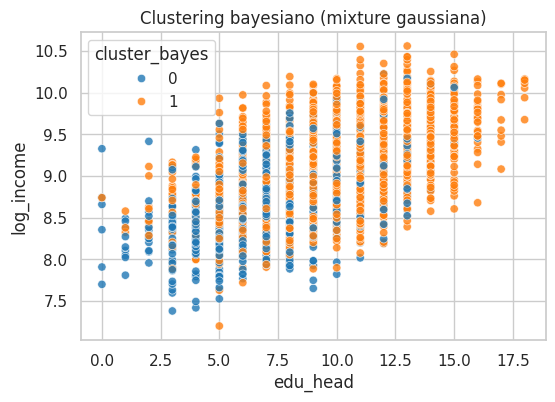

In [29]:

plt.figure(figsize=(6,4))
sns.scatterplot(data=df.sample(4000, random_state=123),
                x="edu_head", y="log_income",
                hue="cluster_bayes", palette="tab10", alpha=0.8)
plt.title("Clustering bayesiano (mixture gaussiana)")
plt.show()



## 6. Comparación rápida entre clusters tradicionales y bayesianos

Podemos comparar el conteo de hogares por cluster y ver si las medias son parecidas o si el modelo bayesiano crea grupos distintos (por ejemplo, separando mejor hogares urbanos/rurales).


In [30]:

pd.crosstab(df["cluster_km"], df["cluster_bayes"])


cluster_bayes,0,1
cluster_km,,
0,1116,0
1,0,1446
2,49,1389


In [31]:
pd.crosstab(df["cluster_bayes"], df["cluster_km"])


cluster_km,0,1,2
cluster_bayes,,,
0,1116,0,49
1,0,1446,1389


In [32]:

df.groupby("cluster_km")[["log_income","hh_size","edu_head","urban"]].mean().round(2)


,log_income,hh_size,edu_head,urban
cluster_km,,,,
0,8.74,4.44,7.49,0.00
1,8.79,4.49,7.86,1.00
2,9.50,4.54,11.74,0.97


In [33]:

df.groupby("cluster_bayes")[["log_income","hh_size","edu_head","urban"]].mean().round(2)


,log_income,hh_size,edu_head,urban
cluster_bayes,,,,
0,8.78,4.47,7.71,0.0
1,9.13,4.50,9.74,1.0
